# Posology Binary Text classification with Transformer

**Author:** [Zakaria Mejdoul](https://www.linkedin.com/in/zakaria-mejdoul-225204159/)<br>
**Date created:** 2022/07/19<br>
**Last modified:** 2022/07/25<br>
**Description:** Implement a Transformer block as a Keras layer and use it for posology binary text classification.

## Setup

In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
from keras.utils import plot_model


from metrics_class import Metrics

# progress bar with pandas
tqdm().pandas()

0it [00:00, ?it/s]


## Implement a Transformer block as a layer

In [2]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim), ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

## Implement embedding layer

Two seperate embedding layers, one for tokens, one for token index (positions).

In [3]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

## Load and prepare dataset

In [4]:
TEXT = 'text'
LABEL = 'label'
data_relative_path = "data"

In [5]:
def load_posology_dataset(data_path=data_relative_path):
    positive_data_path = os.path.join(data_path, 'positive_examples_posology.csv')
    negative_data_path = os.path.join(data_path, 'negative_examples_posology.csv')

    # Load the training data

    pos_df = pd.read_csv(positive_data_path, delimiter=',', header=None, names=['index', TEXT], dtype='str')
    neg_df = pd.read_csv(negative_data_path, delimiter=',', header=None, names=['index', TEXT], dtype='str')

    pos_df = pos_df.iloc[1:, :]
    neg_df = neg_df.iloc[1:, :]

    pos_df = pos_df.iloc[:, 1:]
    neg_df = neg_df.iloc[:, 1:]

    pos_df[LABEL] = 1
    neg_df[LABEL] = 0

    # Concatenate positive and negative dataframes
    full_data = pd.concat([pos_df, neg_df])
    # Shuffle the training data and labels.
    full_data = full_data.sample(frac=1).reset_index(drop=True)

    print(pos_df.head())
    print(neg_df.head())
    print(full_data.head())

    return full_data

In [6]:
data = load_posology_dataset(data_path=data_relative_path)

                                                text  label
1      corgard 40 mg  1 comprimé le matin et le soir      1
2                                      peau atopique      1
3                       quantité suffisante pour 14j      1
4           prendre 1/2 comprime toutes les 8 heures      1
5  19 kggraduation 1 a 4 fois par jour selon beso...      1
                                 text  label
1                       ne 06/05/1995      0
2  centre dimagerie medicale pavillon      0
3                            78,75eur      0
4                    lundi 9h00/18h00      0
5                       59100 roubaix      0
                              text  label
0                15 septembre 2021      0
1  200 mg 1 comprimé matin et soir      1
2            2) paracetamol 1g gel      0
3                           total)      1
4         marignane, le 03/03/2021      0


In [7]:
data.shape

(1953, 2)

## Split Data into Training and Test datasets

In [8]:
x_train, x_test, y_train, y_test = train_test_split(data[TEXT], data[LABEL], random_state=42, stratify=data[LABEL],
                                                    test_size=0.2)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(1562,)
(1562,)
(391,)
(391,)


## Preprocessing

### Text Informations

In [9]:
df = data.copy()

In [10]:
# Extract statistics of the text
df['char_count'] = df[TEXT].map(lambda txt: len(str(txt)))  # Number of characters in the string
df['word_count'] = df[TEXT].apply(lambda x: len(str(x).split()))  # Number of words in the string
df['word_density'] = df['char_count'] / (df['word_count'] + 1)  # Density of word (in char)
print(df.head())

                              text  label  char_count  word_count  \
0                15 septembre 2021      0          17           3   
1  200 mg 1 comprimé matin et soir      1          31           7   
2            2) paracetamol 1g gel      0          21           4   
3                           total)      1           6           1   
4         marignane, le 03/03/2021      0          24           3   

   word_density  
0         4.250  
1         3.875  
2         4.200  
3         3.000  
4         6.000  


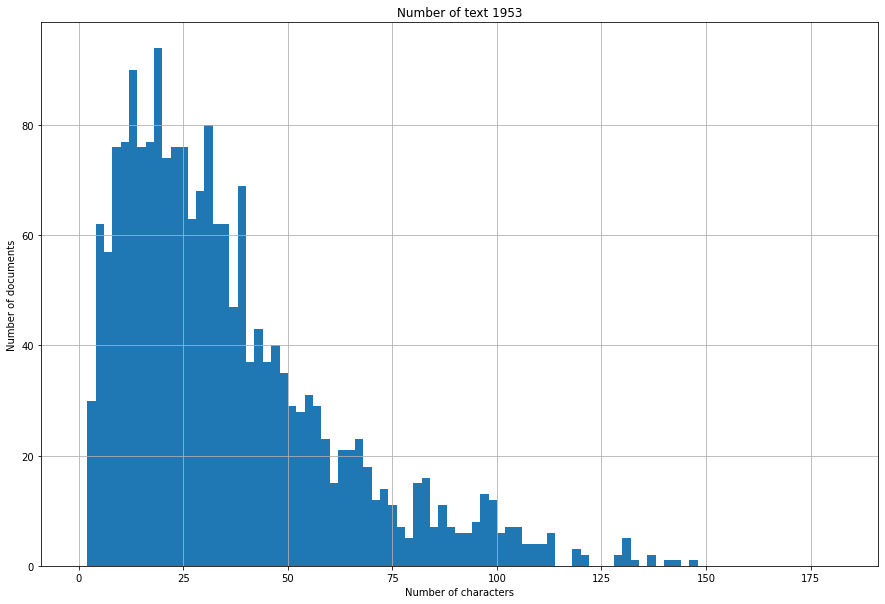

In [11]:
# Show the number of characters per document
plt.figure(figsize=(15, 10))
max_x = 10000 if df.char_count.max() > 10000 else df.char_count.max()
plt.hist(df.char_count.values, bins=range(0, max_x, 2))
plt.title(f"Number of {TEXT} {df.shape[0]}")
plt.xlabel("Number of characters")
plt.ylabel("Number of documents")
plt.grid(True)
plt.show()
# plt.savefig("numb_char.png")

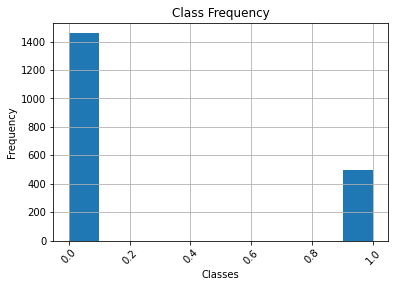

In [12]:
# ---- histogram of the class frequency
df[LABEL].hist(xrot=45)
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.title("Class Frequency")
plt.show()
# plt.savefig("distrib_classes.png")

### Label Encoding

In [13]:
# label encode the target variable 
encoder = sklearn.preprocessing.LabelEncoder()

train_y = encoder.fit_transform(y_train)
test_y = encoder.fit_transform(y_test)

### Word Embeddings

In [14]:
maxlen = 300  # Only consider the first 300 words of each posology text

# create a tokenizer
token = Tokenizer()
token.fit_on_texts(data[TEXT].astype('str'))
word_index = token.word_index

print(len(x_train), "Training sequences")
print(len(x_test), "Validation sequences")
x_train_seq = keras.preprocessing.sequence.pad_sequences(token.texts_to_sequences(x_train.astype('str')), maxlen=maxlen)
x_test_seq = keras.preprocessing.sequence.pad_sequences(token.texts_to_sequences(x_test.astype('str')), maxlen=maxlen)

1562 Training sequences
391 Validation sequences


In [15]:
print(x_train_seq)
print(y_train)
print(x_test_seq)
print(y_test)

[[   0    0    0 ...    0    0 1407]
 [   0    0    0 ...    9   49   18]
 [   0    0    0 ... 2141 2142  258]
 ...
 [   0    0    0 ...    0    0  877]
 [   0    0    0 ...    0    0 2426]
 [   0    0    0 ...  142 2256  573]]
452     0
520     1
1197    0
530     0
729     1
       ..
1145    0
1602    1
1838    0
1486    0
1317    0
Name: label, Length: 1562, dtype: int64
[[   0    0    0 ... 1453 1454 1455]
 [   0    0    0 ...  171   14  438]
 [   0    0    0 ...    0    0  736]
 ...
 [   0    0    0 ...    2    3   16]
 [   0    0    0 ...    0 2128 2129]
 [   0    0    0 ...  108  108   19]]
517     0
1701    0
747     0
516     0
621     0
       ..
1061    0
308     0
28      1
1192    0
655     0
Name: label, Length: 391, dtype: int64


## Create classifier model using transformer layer

Transformer layer outputs one vector for each time step of our input sequence.
Here, we take the mean across all time steps and
use a feed forward network on top of it to classify text.

In [16]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output

In [17]:
def transformers_classifier(word_index, label=None):
    '''
    Function to generate a rcnn for binary or multiclass classification.
    '''
    if label is None:
        label = [0, 1]
    embed_dim = 32  # Embedding size for each token
    num_heads = 2  # Number of attention heads
    ff_dim = 32  # Hidden layer size in feed forward network inside transformer
    vocab_size = len(word_index) + 1
    maxlen = 300
    inputs = layers.Input(shape=(maxlen,))
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(20, activation="relu")(x)
    x = layers.Dropout(0.1)(x)

    outputs = keras.layers.Dense(1 if len(label) <= 2 else len(label),
                                 activation='sigmoid' if len(label) <= 2 else "softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    if len(label) == 2:
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                      loss=tf.losses.BinaryCrossentropy(from_logits=True),
                      metrics=['accuracy'])
    else:
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
                      loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])
    print(model.summary())

    return model

In [18]:
model_transformers = transformers_classifier(word_index, label=[0, 1])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 token_and_position_embeddin  (None, 300, 32)          103040    
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_block (Transfor  (None, 300, 32)          10656     
 merBlock)                                                       
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 32)                0     

In [19]:
plot_model(model_transformers, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


### Early Stopping & Model saving

In [20]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=3)
check_p = tf.keras.callbacks.ModelCheckpoint("save_models/model.h5", save_best_only=True)

## Train and Evaluate

In [21]:
history = model_transformers.fit(
    x_train_seq, train_y,
    epochs=80,
    validation_split=0.2, batch_size=32)

Epoch 1/80


C:\Users\dell\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


40/40 [==============================] - 10s 187ms/step - loss: 0.5685 - accuracy: 0.7494 - val_loss: 0.6135 - val_accuracy: 0.7093

In [22]:
results = model_transformers.evaluate(x_test_seq, test_y)

13/13 [==============================] - 1s 93ms/step - loss: 0.2222 - accuracy: 0.9616

In [23]:
print(results)
print(
    f"\nThe precision of the model is {round(100 * precision_score(test_y, (model_transformers.predict(x_test_seq) > 0.5).astype(int), labels=[0, 1]), 2)}%")

[0.22217343747615814, 0.9616368412971497]
13/13 [==============================] - 1s 69ms/step

The precision of the model is 96.67%


## Displaying Metrics

### Displaying Accuracy, Loss, Precision, Recall, F1-Score and Confusion Matrix

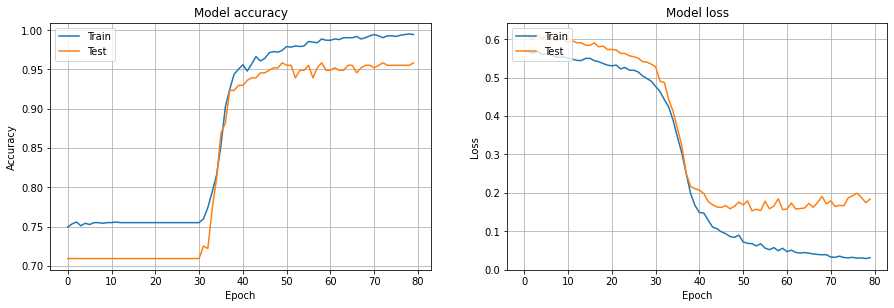

13/13 [==============================] - 1s 73ms/step
              precision    recall  f1-score   support

    negative       0.96      0.99      0.97       292
    positive       0.97      0.88      0.92        99

    accuracy                           0.96       391
   macro avg       0.96      0.93      0.95       391
weighted avg       0.96      0.96      0.96       391

13/13 [==============================] - 1s 69ms

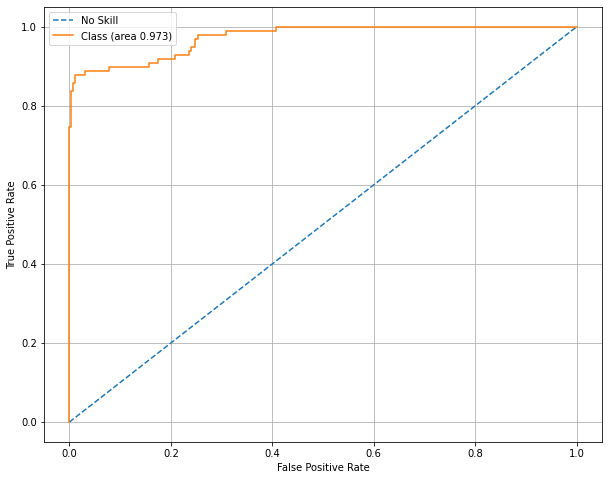

13/13 [==============================] - 1s 74ms/step


Model: f1-score=0.921 AUC=0.951




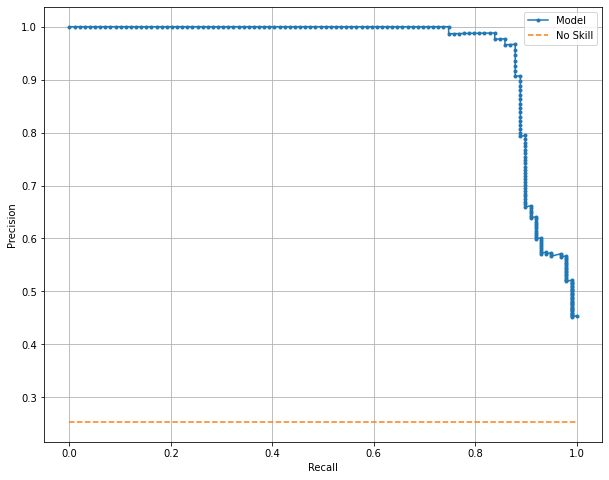

13/13 [==============================] - 1s 66ms/step

Cohen's kappa: 89.54% 

13/13 [==============================] - 1s 67ms/step

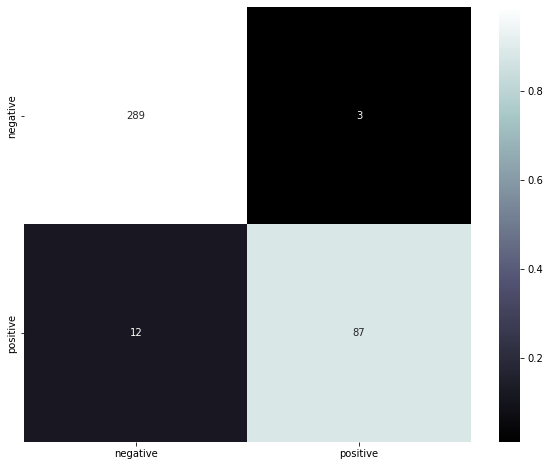

In [24]:
Metric = Metrics()
Metric.metrics_deep_learning(model_transformers, history, x_test_seq, test_y, ["negative", "positive"])

## Predict Some Text

In [25]:
input = "3 mois"
text = pd.Series([input])
text_seq = keras.preprocessing.sequence.pad_sequences(token.texts_to_sequences(text), maxlen=maxlen)

prediction = (model_transformers.predict(text_seq)>0.5).astype(int)
prediction = True if prediction[0,0] == 1 else False
print(f"Prediction of text '{input}' : {prediction}")


1/1 [==============================] - 0s 20ms/step
Prediction of text '3 mois' : True
